# Passive Learning (Manual)

## 1. Data Preprocessing

In [17]:
# Birth-Death Record Linkage Analysis
# A comprehensive record linkage system for linking birth and death records

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from datasketch import MinHash, MinHashLSH
# from jellyfish import jaro_winkler, damerau_levenshtein_distance
from jellyfish import jaro_similarity, jaro_winkler_similarity, levenshtein_distance, damerau_levenshtein_distance
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Birth-Death Record Linkage System")
print("=" * 50)


# ## Step 1: Data Preprocessing



# Load the datasets
print("Loading datasets...")

# clean data (500k)
birth_df = pd.read_csv('linkage data/data_500k/corrupted/birth_records.csv')
death_df = pd.read_csv('linkage data/data_500k/corrupted/death_records.csv')

print(f"Birth records: {birth_df.shape[0]} rows, {birth_df.shape[1]} columns")
print(f"Death records: {death_df.shape[0]} rows, {death_df.shape[1]} columns")


# Examine the structure of both datasets
print("\nBirth Records Columns:")
print(birth_df.columns.tolist())
print(f"\nDeath Records Columns:")
print(death_df.columns.tolist())


# Check for missing values
print("\nMissing values in Birth Records:")
print(birth_df.isnull().sum().head(10))
print(f"\nMissing values in Death Records:")
print(death_df.isnull().sum().head(10))


# Data preprocessing - select relevant columns for linkage
birth_columns = [
    'ID', 'child\'s forname(s)', 'child\'s surname', 'sex', 
    'father\'s forename', 'father\'s surname', 'father\'s occupation',
    'mother\'s forename', 'mother\'s maiden surname', 'mother\'s occupation',
    'birth year', 'address', 'Death'
]

death_columns = [
    'ID', 'forename(s) of deceased', 'surname of deceased', 'sex',
    'father\'s forename', 'father\'s surname', 'father\'s occupation',
    'mother\'s forename', 'mother\'s maiden surname', 'mother\'s occupation',
    'year', 'address', 'age at death'
]

# Create clean datasets
birth_clean = birth_df[birth_columns].copy()
death_clean = death_df[death_columns].copy()

# Rename columns for consistency
birth_clean.columns = ['birth_id', 'forename', 'surname', 'sex', 
                       'father_forename', 'father_surname', 'father_occupation',
                       'mother_forename', 'mother_surname', 'mother_occupation',
                       'birth_year', 'address', 'death_link']

death_clean.columns = ['death_id', 'forename', 'surname', 'sex',
                       'father_forename', 'father_surname', 'father_occupation', 
                       'mother_forename', 'mother_surname', 'mother_occupation',
                       'death_year', 'address', 'age_at_death']

# Fill missing values with empty strings for string columns
string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
               'father_occupation', 'mother_forename', 'mother_surname', 
               'mother_occupation', 'address']

for col in string_cols:
    birth_clean[col] = birth_clean[col].fillna('').astype(str)
    death_clean[col] = death_clean[col].fillna('').astype(str)

print(f"\nCleaned Birth Records: {birth_clean.shape}")
print(f"Cleaned Death Records: {death_clean.shape}")


Birth-Death Record Linkage System
Loading datasets...
Birth records: 1297360 rows, 39 columns
Death records: 1297360 rows, 38 columns

Birth Records Columns:
['ID', 'family', 'marriage', "child's forname(s)", "child's surname", 'birth day', 'birth month', 'birth year', 'address', 'sex', "father's forename", "father's surname", "father's occupation", "mother's forename", "mother's maiden surname", "mother's occupation", "day of parents' marriage", "month of parents' marriage", "year of parents' marriage", "place of parent's marriage", 'illegit', 'notes', 'Death', 'CHILD_IDENTITY', 'MOTHER_IDENTITY', 'FATHER_IDENTITY', 'DEATH_RECORD_IDENTITY', 'PARENT_MARRIAGE_RECORD_IDENTITY', 'FATHER_BIRTH_RECORD_IDENTITY', 'MOTHER_BIRTH_RECORD_IDENTITY', 'MARRIAGE_RECORD_IDENTITY1', 'MARRIAGE_RECORD_IDENTITY2', 'MARRIAGE_RECORD_IDENTITY3', 'MARRIAGE_RECORD_IDENTITY4', 'MARRIAGE_RECORD_IDENTITY5', 'MARRIAGE_RECORD_IDENTITY6', 'MARRIAGE_RECORD_IDENTITY7', 'MARRIAGE_RECORD_IDENTITY8', 'IMMIGRANT_GENERATI

### Ground-truth function

In [18]:

# 
# # Create ground truth labels using Death column from birth records and ID from death records
# def create_ground_truth(birth_df, death_df):
#     """Create ground truth labels for record pairs"""
#     ground_truth = []
    
#     # Create a mapping of death IDs for quick lookup
#     death_ids = set(death_df['death_id'].values)
    
#     for _, birth_row in birth_df.iterrows():
#         birth_id = birth_row['birth_id']
#         death_link = birth_row['death_link']
        
#         for _, death_row in death_df.iterrows():
#             death_id = death_row['death_id']
            
#             # True match if death_link matches death_id
#             if pd.notna(death_link) and int(death_link) == death_id: # connected the ground truth
#                 label = 1  # Match
#             else:
#                 label = 0  # No match
                
#             ground_truth.append({
#                 'birth_id': birth_id,
#                 'death_id': death_id,
#                 'label': label
#             })
    
#     return pd.DataFrame(ground_truth)

# ground_truth_df = create_ground_truth(birth_clean, death_clean)
# print(f"\nGround truth created: {len(ground_truth_df)} record pairs")
# print(f"Positive matches: {ground_truth_df['label'].sum()}")
# print(f"Negative matches: {len(ground_truth_df) - ground_truth_df['label'].sum()}")


# Sample both datasets to XX rows
data_size = 5000
print(f"Sampling datasets to {data_size} rows each...")
print("=" * 40)

# Original sizes
print(f"Original birth records: {len(birth_clean):,}")
print(f"Original death records: {len(death_clean):,}")

# Sample birth records to XX rows
birth_sample_size = min(data_size, len(birth_clean))
birth_sampled = birth_clean.sample(n=birth_sample_size, random_state=42).reset_index(drop=True)

# Sample death records to XX rows  
death_sample_size = min(data_size, len(death_clean))
death_sampled = death_clean.sample(n=death_sample_size, random_state=42).reset_index(drop=True)

print(f"Sampled birth records: {len(birth_sampled):,}")
print(f"Sampled death records: {len(death_sampled):,}")
print(f"Total pairs to create: {len(birth_sampled) * len(death_sampled):,}")

# Use sampled data for ground truth
birth_clean = birth_sampled
death_clean = death_sampled

print("Sampling completed!")
print()



# Create ground truth labels using Death column from birth records and ID from death records
def create_ground_truth(birth_df, death_df):
    """Create ground truth labels for record pairs"""
    import time
    
    print("Creating ground truth labels...")
    print("=" * 40)
    
    ground_truth = []
    
    # Get total counts for progress tracking
    total_birth_records = len(birth_df)
    total_death_records = len(death_df)
    total_pairs = total_birth_records * total_death_records
    
    print(f"Birth records: {total_birth_records}")
    print(f"Death records: {total_death_records}")
    print(f"Total pairs to process: {total_pairs:,}")
    print()
    
    # Create a mapping of death IDs for quick lookup
    death_ids = set(death_df['death_id'].values)
    
    start_time = time.time()
    pairs_processed = 0
    matches_found = 0
    
    for birth_idx, birth_row in birth_df.iterrows():
        birth_id = birth_row['birth_id']
        death_link = birth_row['death_link']
        
        # Progress update every 100 birth records
        if (birth_idx + 1) % 100 == 0 or (birth_idx + 1) == total_birth_records:
            elapsed_time = time.time() - start_time
            progress_pct = ((birth_idx + 1) / total_birth_records) * 100
            pairs_so_far = (birth_idx + 1) * total_death_records
            
            print(f"Progress: {birth_idx + 1:4d}/{total_birth_records} birth records "
                  f"({progress_pct:5.1f}%) | "
                  f"Pairs: {pairs_so_far:7,} | "
                  f"Matches: {matches_found:4d} | "
                  f"Time: {elapsed_time:6.1f}s")
        
        for death_idx, death_row in death_df.iterrows():
            death_id = death_row['death_id']
            
            # True match if death_link matches death_id
            if pd.notna(death_link) and int(death_link) == death_id:
                label = 1  # Match
                matches_found += 1
            else:
                label = 0  # No match
                
            ground_truth.append({
                'birth_id': birth_id,
                'death_id': death_id,
                'label': label
            })
            
            pairs_processed += 1
    
    total_time = time.time() - start_time
    print()
    print("Ground truth creation completed!")
    print(f"Total time: {total_time:.1f} seconds")
    print(f"Pairs per second: {pairs_processed/total_time:,.0f}")
    print()
    
    return pd.DataFrame(ground_truth)

# Create ground truth with progress tracking
ground_truth_df = create_ground_truth(birth_clean, death_clean)

print(f"Ground truth created: {len(ground_truth_df):,} record pairs")
print(f"Positive matches: {ground_truth_df['label'].sum():,}")
print(f"Negative matches: {len(ground_truth_df) - ground_truth_df['label'].sum():,}")
print(f"Match ratio: {ground_truth_df['label'].sum()/len(ground_truth_df)*100:.4f}%")


Sampling datasets to 5000 rows each...
Original birth records: 1,297,360
Original death records: 1,297,360
Sampled birth records: 5,000
Sampled death records: 5,000
Total pairs to create: 25,000,000
Sampling completed!

Creating ground truth labels...
Birth records: 5000
Death records: 5000
Total pairs to process: 25,000,000

Progress:  100/5000 birth records (  2.0%) | Pairs: 500,000 | Matches:   99 | Time:    5.1s
Progress:  200/5000 birth records (  4.0%) | Pairs: 1,000,000 | Matches:  199 | Time:   10.2s
Progress:  300/5000 birth records (  6.0%) | Pairs: 1,500,000 | Matches:  299 | Time:   15.4s
Progress:  400/5000 birth records (  8.0%) | Pairs: 2,000,000 | Matches:  399 | Time:   20.5s
Progress:  500/5000 birth records ( 10.0%) | Pairs: 2,500,000 | Matches:  499 | Time:   25.6s
Progress:  600/5000 birth records ( 12.0%) | Pairs: 3,000,000 | Matches:  599 | Time:   30.7s
Progress:  700/5000 birth records ( 14.0%) | Pairs: 3,500,000 | Matches:  699 | Time:   36.1s
Progress:  800/5

In [19]:
# ground_truth_df.loc[ground_truth_df['label'] == 1]
print(ground_truth_df)
print(ground_truth_df.loc[ground_truth_df['label'] == 1])

          birth_id  death_id  label
0          1474005   1474005      1
1          1474005   1832197      0
2          1474005   1874508      0
3          1474005   1588408      0
4          1474005   2243616      0
...            ...       ...    ...
24999995   1132570   1603092      0
24999996   1132570   1055210      0
24999997   1132570    738606      0
24999998   1132570   1890722      0
24999999   1132570   1132570      1

[25000000 rows x 3 columns]
          birth_id  death_id  label
0          1474005   1474005      1
5001       1832197   1832197      1
10002      1874508   1874508      1
15003      1588408   1588408      1
20004      2243616   2243616      1
...            ...       ...    ...
24979995   1603092   1603092      1
24984996   1055210   1055210      1
24989997    738606    738606      1
24994998   1890722   1890722      1
24999999   1132570   1132570      1

[5000 rows x 3 columns]


## 2. Indexing (Blocking)

In [20]:
def create_minhash_signature(record, columns):
    """Create MinHash signature for a record"""
    minhash = MinHash()
    for col in columns:
        data = str(record[col]).lower()
        for token in data.split():
            minhash.update(token.encode('utf8'))
    return minhash

def blocking_with_minhash(birth_df, death_df, threshold):
    """Create blocks using MinHash LSH"""
    print(f"Creating blocks with threshold: {threshold}")
    
    # Columns to use for blocking
    blocking_cols = ['forename', 'surname', 'father_surname', 'mother_surname']
    
    # Create MinHash signatures for all records
    birth_signatures = {}
    death_signatures = {}
    
    print("Creating MinHash signatures for birth records...")
    for idx, row in birth_df.iterrows():
        birth_signatures[f"birth_{row['birth_id']}"] = create_minhash_signature(row, blocking_cols)
    
    print("Creating MinHash signatures for death records...")
    for idx, row in death_df.iterrows():
        death_signatures[f"death_{row['death_id']}"] = create_minhash_signature(row, blocking_cols)
    
    # Create LSH index
    lsh = MinHashLSH(threshold=threshold)
    
    # Insert all signatures
    print("Inserting signatures into LSH index...")
    for key, sig in birth_signatures.items():
        lsh.insert(key, sig)
    for key, sig in death_signatures.items():
        lsh.insert(key, sig)
    
    # Generate candidate pairs and detailed blocking information
    candidate_pairs = []
    birth_blocks = {}  # Dictionary to store blocks for each birth record
    
    print("Generating candidate pairs...")
    for birth_key, birth_sig in birth_signatures.items():
        similar_records = lsh.query(birth_sig)
        birth_id = int(birth_key.split('_')[1])
        
        # Find death records in the same block
        death_records_in_block = []
        for similar_key in similar_records:
            if similar_key.startswith('death_'):
                death_id = int(similar_key.split('_')[1])
                candidate_pairs.append((birth_id, death_id))
                death_records_in_block.append(death_id)
        
        # Store block information (just for statistical purposes)
        birth_blocks[birth_id] = {
            'birth_id': birth_id,
            'death_records': death_records_in_block,
            'total_similar_records': len(similar_records),
            'death_count': len(death_records_in_block)
        }
    
    # Remove duplicates from candidate pairs
    candidate_pairs = list(set(candidate_pairs))
    
    print(f"Generated {len(candidate_pairs)} candidate pairs") # for computation
    print(f"Generated {len(birth_blocks)} birth blocks") # for illustration, exploration
    
    return candidate_pairs, birth_blocks

# Generate candidate pairs through blocking
candidate_pairs, birth_blocks = blocking_with_minhash(birth_clean, death_clean, threshold=0.7)


Creating blocks with threshold: 0.7
Creating MinHash signatures for birth records...
Creating MinHash signatures for death records...
Inserting signatures into LSH index...
Generating candidate pairs...
Generated 2795 candidate pairs
Generated 5000 birth blocks


- checking the candidate pair that is same with the birth_blocks variable
- the diff is only the data types
- And, birth_blocks count the one that dont have the death (candidate)

In [21]:
def checking_candidate_pairs_by_ID(checking_id):
    r = []
    for i in range(len(candidate_pairs)):
        if candidate_pairs[i][0] == checking_id:
            r.append(candidate_pairs[i])
    print(f"\nCandidate pairs for birth ID {checking_id}: {r}")
    print(f"Total candidate pairs for birth ID {checking_id}: {len(r)}")

checking_candidate_pairs_by_ID(checking_id=1383518)
checking_candidate_pairs_by_ID(checking_id=963232)
checking_candidate_pairs_by_ID(checking_id=1276997)




Candidate pairs for birth ID 1383518: []
Total candidate pairs for birth ID 1383518: 0

Candidate pairs for birth ID 963232: []
Total candidate pairs for birth ID 963232: 0

Candidate pairs for birth ID 1276997: []
Total candidate pairs for birth ID 1276997: 0


### Blocking Statistics


Detailed Blocking Analysis:
Sample Blocks (First 15 Birth Records):
----------------------------------------
Block 1:
  Birth ID: 1474005
  Associated Death Records: []
  Number of Death Records: 0
  Total Similar Records: 1
  Birth Record: Cohneor Sauners
  No death records in this block
---
Block 2:
  Birth ID: 1832197
  Associated Death Records: []
  Number of Death Records: 0
  Total Similar Records: 1
  Birth Record: Andrew Jackson
  No death records in this block
---
Block 3:
  Birth ID: 1874508
  Associated Death Records: []
  Number of Death Records: 0
  Total Similar Records: 1
  Birth Record: K?ira Sim
  No death records in this block
---
Block 4:
  Birth ID: 1588408
  Associated Death Records: [1588408]
  Number of Death Records: 1
  Total Similar Records: 2
  Birth Record: Hebe Thomson
  Death Record(s):
    ID 1588408: Hebe Thomson
---
Block 5:
  Birth ID: 2243616
  Associated Death Records: []
  Number of Death Records: 0
  Total Similar Records: 1
  Birth Record: Whitel

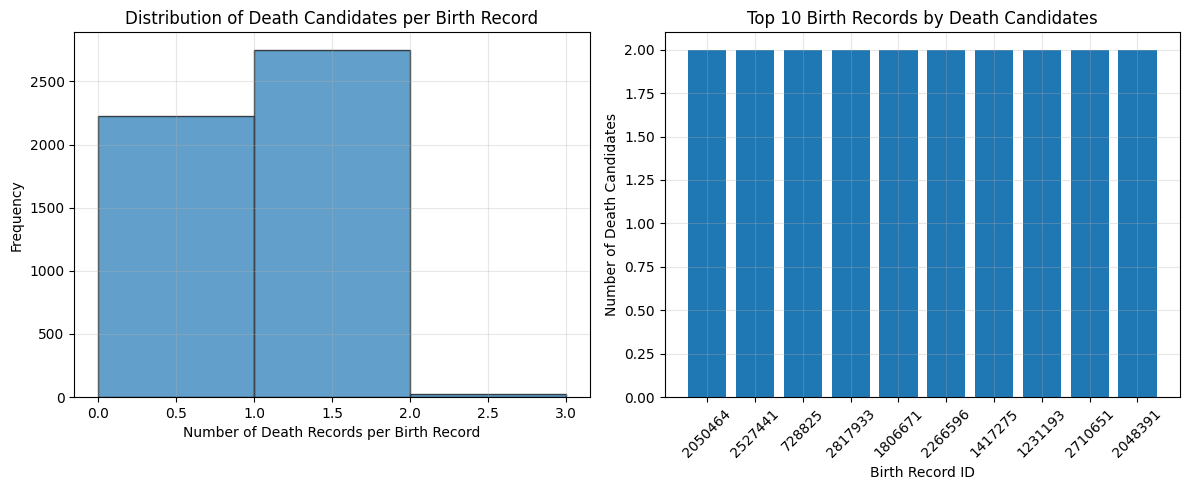


Birth Records with Multiple Death Candidates:
--------------------------------------------------
Found 22 birth records with multiple death candidates:

Birth ID 2050464: Sophie Macleod
  Death candidates (2):
    ID 2050464: Sophie Macleod (Age: 37)
    ID 748738: Samira Macleod (Age: 67)

Birth ID 2527441: Samuel Maclean
  Death candidates (2):
    ID 2527441: Samuel Maclean (Age: 0)
    ID 1767731: Samuel Mcgivern (Age: 81)

Birth ID 728825: Joshua Smith
  Death candidates (2):
    ID 1836199: Morton Joshua (Age: 83)
    ID 728825: Joshua Smith (Age: 71)

Birth ID 2817933: Daniel Carmichael
  Death candidates (2):
    ID 2817933: Daniel Carmichael (Age: 0)
    ID 974521: Daniel Stewart (Age: 75)

Birth ID 1806671: Patrick Ewen
  Death candidates (2):
    ID 1806671: Patrick Ewen (Age: 77)
    ID 1567198: Anderson Shannon (Age: 61)

Birth ID 2266596: Molly Mckenzie
  Death candidates (2):
    ID 2266596: Molly Mckenzie (Age: 49)
    ID 821708: Molly Scott (Age: 56)

Birth ID 1417275

In [22]:
# Show detailed blocking results
print("\nDetailed Blocking Analysis:")
print("=" * 50)

# Show first 15 birth records and their associated death records
print("Sample Blocks (First 15 Birth Records):")
print("-" * 40)

birth_ids_sample = list(birth_blocks.keys())[:15]
for i, birth_id in enumerate(birth_ids_sample):
    block_info = birth_blocks[birth_id]
    print(f"Block {i+1}:")
    print(f"  Birth ID: {birth_id}")
    print(f"  Associated Death Records: {block_info['death_records']}")
    print(f"  Number of Death Records: {block_info['death_count']}")
    print(f"  Total Similar Records: {block_info['total_similar_records']}")
    
    # Show names for context
    birth_record = birth_clean[birth_clean['birth_id'] == birth_id].iloc[0]
    print(f"  Birth Record: {birth_record['forename']} {birth_record['surname']}")
    
    if block_info['death_records']:
        print(f"  Death Record(s):")
        for death_id in block_info['death_records']:
            death_record = death_clean[death_clean['death_id'] == death_id]
            if not death_record.empty:
                death_record = death_record.iloc[0]
                print(f"    ID {death_id}: {death_record['forename']} {death_record['surname']}")
    else:
        print(f"  No death records in this block")
    print("---")


# Statistical analysis of blocking results
print(f"\nBlocking Statistics:")
print("=" * 30)

death_counts = [block_info['death_count'] for block_info in birth_blocks.values()]
birth_records_with_deaths = sum(1 for count in death_counts if count > 0)
birth_records_without_deaths = sum(1 for count in death_counts if count == 0)

print(f"Total birth records: {len(birth_blocks)}")
print(f"Birth records with death candidates: {birth_records_with_deaths}")
print(f"Birth records without death candidates: {birth_records_without_deaths}")
print(f"Average death candidates per birth record: {np.mean(death_counts):.2f}")
print(f"Max death candidates for a single birth record: {max(death_counts)}")


# Distribution of death record counts per birth record
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(death_counts, bins=range(max(death_counts)+2), alpha=0.7, edgecolor='black')
plt.xlabel('Number of Death Records per Birth Record')
plt.ylabel('Frequency')
plt.title('Distribution of Death Candidates per Birth Record')
plt.grid(True, alpha=0.3)

# Show birth records with most death candidates
plt.subplot(1, 2, 2)
top_candidates = sorted(birth_blocks.items(), key=lambda x: x[1]['death_count'], reverse=True)[:10]
birth_ids = [str(item[0]) for item in top_candidates]
death_counts_top = [item[1]['death_count'] for item in top_candidates]

plt.bar(birth_ids, death_counts_top)
plt.xlabel('Birth Record ID')
plt.ylabel('Number of Death Candidates')
plt.title('Top 10 Birth Records by Death Candidates')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Show birth records with multiple death candidates
print(f"\nBirth Records with Multiple Death Candidates:")
print("-" * 50)

multiple_candidates = {birth_id: info for birth_id, info in birth_blocks.items() 
                      if info['death_count'] > 1}

if multiple_candidates:
    print(f"Found {len(multiple_candidates)} birth records with multiple death candidates:")
    
    for birth_id, block_info in sorted(multiple_candidates.items(), 
                                      key=lambda x: x[1]['death_count'], reverse=True)[:10]:
        birth_record = birth_clean[birth_clean['birth_id'] == birth_id].iloc[0]
        print(f"\nBirth ID {birth_id}: {birth_record['forename']} {birth_record['surname']}")
        print(f"  Death candidates ({block_info['death_count']}):")
        
        for death_id in block_info['death_records']:
            death_record = death_clean[death_clean['death_id'] == death_id]
            if not death_record.empty:
                death_record = death_record.iloc[0]
                print(f"    ID {death_id}: {death_record['forename']} {death_record['surname']} "
                      f"(Age: {death_record['age_at_death']})")
else:
    print("No birth records have multiple death candidates with this threshold.")


# Summary table
print(f"\nBlocking Summary Table:")
print("=" * 25)

summary_data = []
for count in range(max(death_counts) + 1):
    freq = death_counts.count(count)
    percentage = (freq / len(death_counts)) * 100
    summary_data.append({
        'Death_Candidates': count,
        'Birth_Records': freq,
        'Percentage': f"{percentage:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


## 3. Comparing
### Feature
- from append()
- these are the features in each columns
1. jaro winkler
2. damerau levenshtein
3. jaccard similarity
4. age consistency 

In [23]:


# ## Step 3: Comparing (Feature Engineering)


def jaccard_similarity(str1, str2):
    """Calculate Jaccard similarity between two strings"""
    set1 = set(str1.lower().split())
    set2 = set(str2.lower().split())
    if len(set1.union(set2)) == 0:
        return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

def calculate_features(birth_record, death_record):
    """Calculate similarity features between two records"""
    features = []
    
    # String comparison columns
    string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
                   'mother_forename', 'mother_surname', 'address']
    
    for col in string_cols:
        birth_val = str(birth_record[col]).lower()
        death_val = str(death_record[col]).lower()
        
        # Jaro-Winkler similarity
        jw_sim = jaro_winkler_similarity(birth_val, death_val)
        features.append(jw_sim)
        # features.append({'col': col, 'jw_sim': jw_sim})
        
        # Damerau-Levenshtein distance (normalized)
        dl_dist = damerau_levenshtein_distance(birth_val, death_val)
        max_len = max(len(birth_val), len(death_val))
        dl_sim = 1 - (dl_dist / max_len) if max_len > 0 else 1
        features.append(dl_sim)
        # features.append({'col': col, 'dl_sim': dl_sim})
        
        # Jaccard similarity
        jaccard_sim = jaccard_similarity(birth_val, death_val)
        features.append(jaccard_sim)
        # features.append({'col': col, 'jaccard_sim': jaccard_sim})
    
    # Age consistency (if available)
    # if pd.notna(birth_record['birth_year']) and pd.notna(death_record['death_year']) and pd.notna(death_record['age_at_death']):
    #     expected_birth_year = death_record['death_year'] - death_record['age_at_death']
    #     age_diff = abs(birth_record['birth_year'] - expected_birth_year)
    #     age_consistency = 1 / (1 + age_diff)  # Exponential decay
    #     features.append(age_consistency)
    #     # features.append({'col': 'age_consistency', 'value': age_consistency})
    # else:
    #     features.append(0.5)  # Neutral value when age info is missing
    #     # features.append({'col': 'age_consistency', 'value': 0.5})

    try:
        # Convert to numeric, handling potential string inputs
        birth_year = pd.to_numeric(birth_record['birth_year'], errors='coerce')
        death_year = pd.to_numeric(death_record['death_year'], errors='coerce')  
        age_at_death = pd.to_numeric(death_record['age_at_death'], errors='coerce')
        
        if pd.notna(birth_year) and pd.notna(death_year) and pd.notna(age_at_death):
            expected_birth_year = death_year - age_at_death
            age_diff = abs(birth_year - expected_birth_year)
            age_consistency = 1 / (1 + age_diff)  # Exponential decay
            # features.append({'col': 'age_consistency', 'value': age_consistency})
            features.append(age_consistency)
        else:
            # features.append({'col': 'age_consistency', 'value': 0.5})
            features.append(0.5)
    except:
        # Fallback if conversion fails
        # features.append({'col': 'age_consistency', 'value': 0.5})
        features.append(0.5)
    
    return features

# Create feature matrix
print("Calculating features for candidate pairs...")
X = []
y = []

# Create lookup dictionaries for faster access
birth_lookup = {row['birth_id']: row for _, row in birth_clean.iterrows()}
death_lookup = {row['death_id']: row for _, row in death_clean.iterrows()}
ground_truth_lookup = {(row['birth_id'], row['death_id']): row['label'] 
                      for _, row in ground_truth_df.iterrows()}

for birth_id, death_id in candidate_pairs: # use candidate pairs only
    if birth_id in birth_lookup and death_id in death_lookup:
        birth_record = birth_lookup[birth_id]
        death_record = death_lookup[death_id]
        
        features = calculate_features(birth_record, death_record)
        X.append(features)
        
        # Get ground truth label
        label = ground_truth_lookup.get((birth_id, death_id))
        y.append(label)

X = np.array(X)
y = np.array(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Positive class ratio: {np.sum(y)/len(y):.4f}")


Calculating features for candidate pairs...
Feature matrix shape: (2795, 25)
Labels shape: (2795,)
Positive class ratio: 0.9903


In [24]:
# y[0:20]
X[5]

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5])

In [25]:
y


array([1, 1, 1, ..., 1, 1, 1], shape=(2795,))

## 4. Classification
### Cross Validation (5 folds)
- with Metrics performance; Precision, Recall, F1
- draw Plots

In [26]:


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## randomly select 100 candidate pairs for testing *****



print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training positive ratio: {np.sum(y_train)/len(y_train):.4f}")
print(f"Test positive ratio: {np.sum(y_test)/len(y_test):.4f}")


# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Cross-Validation Analysis (on training data only)
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer

print("\nPerforming Cross-Validation Analysis (Training Data Only)...")
print("=" * 60)


# Check if we have enough samples for cross-validation
if len(np.unique(y_train)) < 2:
    print("Warning: Only one class present in the training data. Cannot perform classification.")
    print("This might indicate:")
    print("1. Threshold too high (try lowering it)")
    print("2. Ground truth issues")
    print("3. No actual matches in the candidate pairs")
    
    # Show class distribution
    unique_classes, counts = np.unique(y_train, return_counts=True)
    for cls, count in zip(unique_classes, counts):
        print(f"Class {cls}: {count} samples")
else:
    # Define custom scorers
    scoring = {
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'f1': make_scorer(f1_score, zero_division=0)
    }

    
    # Perform 5-fold stratified cross-validation on training data only
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("5-Fold Stratified Cross-Validation Results (Training Data Only):")
    print("-" * 60)

    # Initialize classifier for CV
    rf_classifier = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
    )

    # Perform cross-validation on training data only
    cv_results = cross_validate(
        rf_classifier, X_train_scaled, y_train, 
        cv=cv, scoring=scoring, 
        return_train_score=True,
        n_jobs=-1
    )

    
    # Display cross-validation results
    metrics = ['precision', 'recall', 'f1']
    for metric in metrics:
        test_scores = cv_results[f'test_{metric}'] # test_precision, test_recall, test_f1
        train_scores = cv_results[f'train_{metric}'] # train_precision, train_recall, train_f1
        
        print(f"\n{metric.upper()}:")
        print(f"  Validation:  {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")
        print(f"  Training:    {train_scores.mean():.4f} (+/- {train_scores.std() * 2:.4f})")
        print(f"  CV Folds:    {test_scores}")




Training set: 1956 samples
Test set: 839 samples
Training positive ratio: 0.9903
Test positive ratio: 0.9905

Performing Cross-Validation Analysis (Training Data Only)...
5-Fold Stratified Cross-Validation Results (Training Data Only):
------------------------------------------------------------

PRECISION:
  Validation:  0.9990 (+/- 0.0041)
  Training:    1.0000 (+/- 0.0000)
  CV Folds:    [1.         1.         1.         1.         0.99485861]

RECALL:
  Validation:  0.9995 (+/- 0.0021)
  Training:    0.9996 (+/- 0.0006)
  CV Folds:    [1.         0.99742268 1.         1.         1.        ]

F1:
  Validation:  0.9992 (+/- 0.0021)
  Training:    0.9998 (+/- 0.0003)
  CV Folds:    [1.         0.99870968 1.         1.         0.99742268]


### Fit the model and do the prediction

In [27]:


# Train Random Forest classifier on training set
print(f"\n\nTraining Final Model on Training Set:")
print("-" * 40)


rf_classifier.fit(X_train_scaled, y_train)


# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1] # select all rows, 1 col

print(y_pred)
print("-"* 40)
count_of_ones = (y_pred == 1).sum()
count_of_zeros = (y_pred == 0).sum()
print("COunt of 0: ", count_of_zeros)
print("COunt of 1: ", count_of_ones)
print("-"* 40)
print(y_pred_proba)
print("Classification completed!")




Training Final Model on Training Set:
----------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 

## 5. Evaluation
- with the test set

Classification Results:
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Confusion Matrix:
[[  8   0]
 [  0 831]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00       831

    accuracy                           1.00       839
   macro avg       1.00      1.00      1.00       839
weighted avg       1.00      1.00      1.00       839



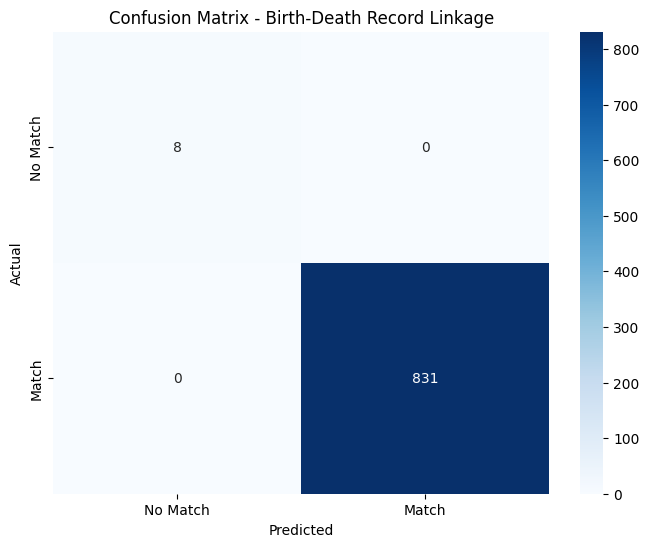


Top 10 Most Important Features:
                    feature  importance
15       mother_forename_jw    0.247589
16       mother_forename_dl    0.156540
24          age_consistency    0.137845
9        father_forename_jw    0.121509
10       father_forename_dl    0.093387
17  mother_forename_jaccard    0.080473
11  father_forename_jaccard    0.058933
13        father_surname_dl    0.018961
18        mother_surname_jw    0.017295
12        father_surname_jw    0.015269


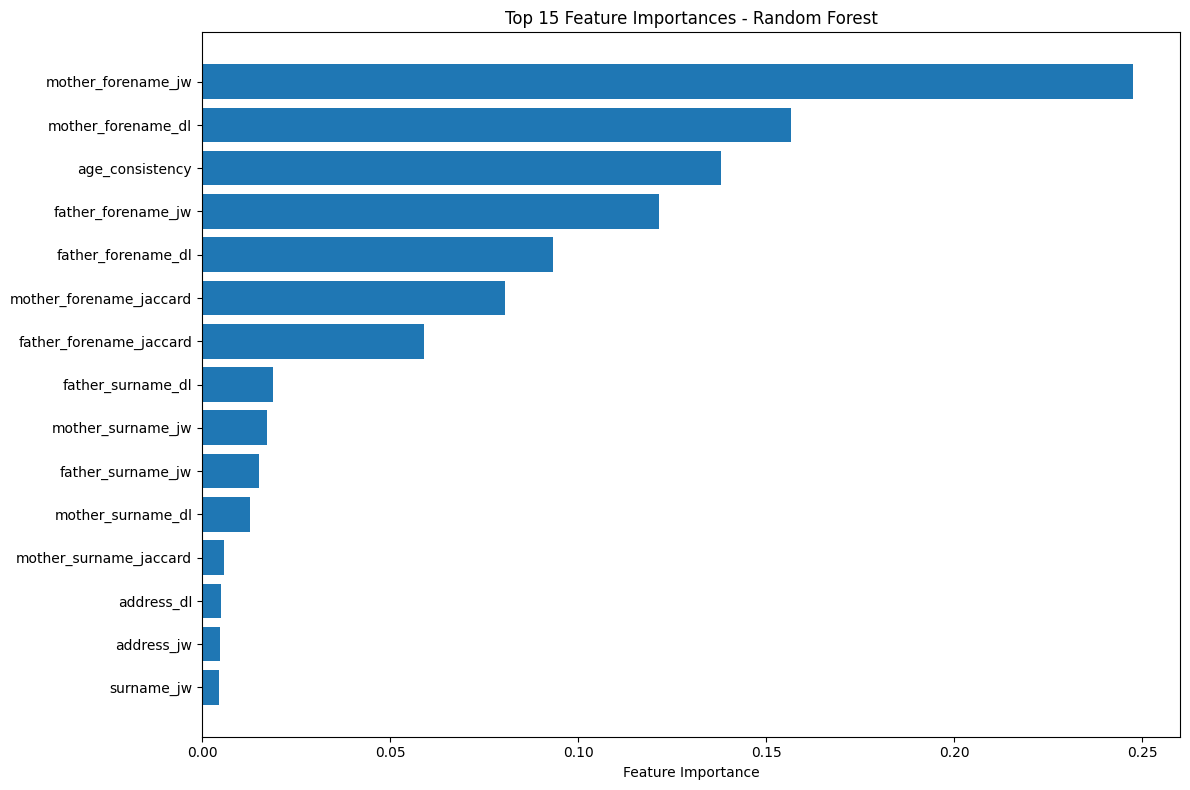

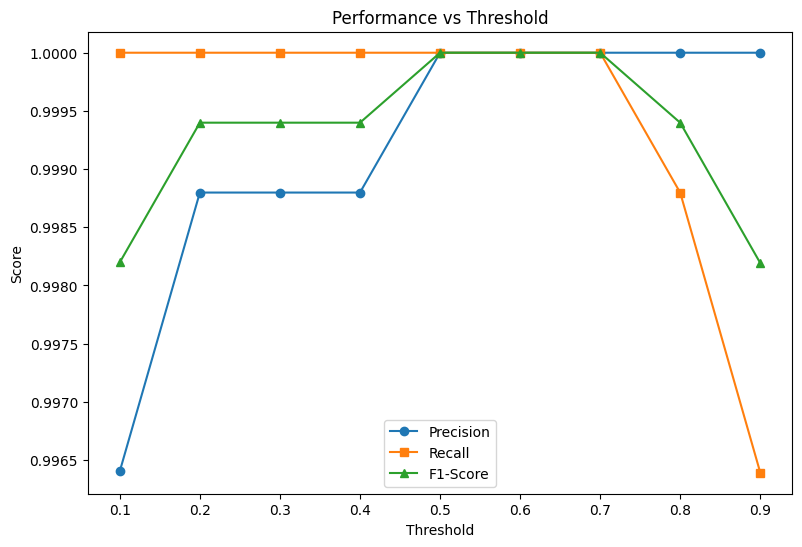


Cross-Validation Summary:
5-Fold Stratified Cross-Validation Results:
Precision: 0.9990 (+/- 0.0041)
Recall: 0.9995 (+/- 0.0021)
F1: 0.9992 (+/- 0.0021)

Final Model Performance on Test Set:
Total record pairs evaluated: 2795
Actual matches in test set: 831
Predicted matches in test set: 831
True positives: 831
False positives: 0
False negatives: 0
True negatives: 8

Test Set Performance:
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Sample predictions:
   birth_id  death_id  actual_label  predicted_label  prediction_probability
0   1539676   1539676             1                1                1.000000
1   3425963   3425963             1                1                1.000000
2   1639782   1639782             1                1                1.000000
3    973243    973243             1                1                0.956422
4   1572714   1572714             1                1                0.998094
5   2224543   2224543             1                1                1.0000

In [28]:


# ## Step 5: Evaluation


# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Classification Results:")
print("=" * 30)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))


# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Match', 'Match'],
            yticklabels=['No Match', 'Match'])
plt.title('Confusion Matrix - Birth-Death Record Linkage')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Feature importance analysis
feature_names = []
string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
               'mother_forename', 'mother_surname', 'address']

for col in string_cols:
    feature_names.extend([f'{col}_jw', f'{col}_dl', f'{col}_jaccard'])
feature_names.append('age_consistency')

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))


# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Analyze prediction probabilities
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='No Match', color='red')
# plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Match', color='blue')
# plt.xlabel('Prediction Probability')
# plt.ylabel('Frequency')
# plt.title('Distribution of Prediction Probabilities')
# plt.legend()

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

thresholds = np.arange(0.1, 1.0, 0.1)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int) 
    # the cutoff point of pred_proba to know what probabilities should we say "this is a match"
    if np.sum(y_pred_thresh) > 0:
        precisions.append(precision_score(y_test, y_pred_thresh))
        recalls.append(recall_score(y_test, y_pred_thresh))
        f1_scores.append(f1_score(y_test, y_pred_thresh))
    else:
        precisions.append(0)
        recalls.append(0)
        f1_scores.append(0)

plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='s')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance vs Threshold')
plt.legend()
# plt.grid(True)

# plt.tight_layout()
plt.show()


# Summary statistics
print("\nCross-Validation Summary:")
print("=" * 50)
print("5-Fold Stratified Cross-Validation Results:")
for metric in metrics:
    test_scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()}: {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")

print("\nFinal Model Performance on Test Set:")
print("=" * 50)
print(f"Total record pairs evaluated: {len(candidate_pairs)}")
print(f"Actual matches in test set: {np.sum(y_test)}")
print(f"Predicted matches in test set: {np.sum(y_pred)}")
print(f"True positives: {cm[1,1]}")
print(f"False positives: {cm[0,1]}")
print(f"False negatives: {cm[1,0]}")
print(f"True negatives: {cm[0,0]}")
print(f"\nTest Set Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


# Save results (optional)
results_df = pd.DataFrame({
    'birth_id': [candidate_pairs[i][0] for i in range(len(X_test))],
    'death_id': [candidate_pairs[i][1] for i in range(len(X_test))],
    'actual_label': y_test,
    'predicted_label': y_pred,
    'prediction_probability': y_pred_proba
})

print(f"\nSample predictions:")
print(results_df.head(10))